In [1]:
from os import getcwd, path
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

BASE_PATH = path.dirname(getcwd())
sys.path.append(BASE_PATH)

from entities_recognition.bilstm.train import trainIters, evaluate_all
from config import START_TAG, STOP_TAG

import torch
print(torch.__version__)

0.4.0a0+5463a4a


In [2]:
TRAIN_PATH = path.join(BASE_PATH, 'data/CoNLL-2003/eng.train')
print(TRAIN_PATH)

/Users/2359media/Documents/botbot-nlp/data/CoNLL-2003/eng.train


In [3]:
import io
import string

def ident(x):
    return x

def read_conll_2003(filename):
    all_data = []

    current_txt = []
    current_tags = []
    tagset = []

    fin = io.open(filename, 'r', encoding='utf-8', newline='\n', errors='ignore')
    for line in fin:
        line = line.strip()
        if len(line) > 0: # skip blank lines
            tmp = line.split(' ')
            if tmp[0] != '-DOCSTART-':
                current_txt.append(tmp[0])
                current_tags.append(tmp[-1])
                tagset.append(tmp[-1])
        else:
            if len(current_txt) > 0:
                all_data.append((current_txt, ' '.join(current_tags)))
                current_txt = []
                current_tags = []
    fin.close()

    tagset = list(set(tagset))
    tag_to_ix = {tag: key for key, tag in enumerate(tagset)}
    tag_to_ix[START_TAG] = len(tagset)
    tag_to_ix[STOP_TAG] = len(tagset) + 1

    print(tag_to_ix)
    print('Loaded %s sentences' % len(all_data))
    
    return tag_to_ix, all_data

In [4]:
from entities_recognition.bilstm.predict import read_tags

tag_to_ix, training_data = read_conll_2003(TRAIN_PATH)
result = []
for sentence, tag_seq in training_data:
    assert len(sentence) == len(tag_seq.split(' '))
#     print(read_tags(tokens_in, tag_seq.split(' ')))

{'I-ORG': 0, 'B-MISC': 1, 'O': 2, 'I-LOC': 3, 'I-MISC': 4, 'B-LOC': 5, 'B-ORG': 6, 'I-PER': 7, '<START>': 8, '<STOP>': 9}
Loaded 14041 sentences


Importing /Users/2359media/Documents/botbot-nlp/data/fasttext/crawl-300d-2M.vec...
Test training with lr: 0.01 Final loss: 343309.84375
Test training with lr: 0.02 Final loss: 152355.59375
Test training with lr: 0.03 Final loss: 131883.15625
Test training with lr: 0.04 Final loss: 105428.25
Test training with lr: 0.05 Final loss: 88013.2734375
Test training with lr: 0.060000000000000005 Final loss: 81104.0703125
Test training with lr: 0.07 Final loss: 74047.6171875
Test training with lr: 0.08 Final loss: 72592.28125
Test training with lr: 0.09 Final loss: 63606.625
Test training with lr: 0.09999999999999999 Final loss: 62646.62109375
Test training with lr: 0.10999999999999999 Final loss: 60868.56640625
Test training with lr: 0.11999999999999998 Final loss: 58218.05859375
Test training with lr: 0.12999999999999998 Final loss: 55053.1796875
Test training with lr: 0.13999999999999999 Final loss: 54098.26171875
Test training with lr: 0.15 Final loss: 51979.2578125
Test training with lr: 0.

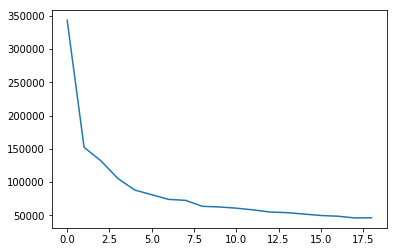

In [ ]:
# find optimal learning rate
lr_delta = 1e-2
lr = 0
loss_history = []
while True:
    lr += lr_delta
    losses, _ = trainIters(training_data,
                           tag_to_ix,
                           learning_rate=lr,
                           gradual_unfreeze=True,
                           weight_decay=0,
                           optimizer='sgd',
                           n_iters=3,
                           tokenizer=ident,
                           verbose=0)
    print('Test training with lr:', lr, 'Final loss:', losses[-1].item())
    
    loss_history.append(losses[-1].item())

    if losses[0] < losses[-1]: # loss is increasing
        best_lr = lr - lr_delta
        break
        
    if len(loss_history) > 2 and loss_history[-1] > loss_history[-2]:
        best_lr = lr - lr_delta
        break

print('Best LR found:', best_lr)

plt.figure()
fig, ax = plt.subplots()
plt.plot(loss_history)

In [ ]:
losses, model = trainIters(training_data, 
                           tag_to_ix,
                           learning_rate=best_lr,
                           gradual_unfreeze=True,
                           weight_decay=0,
                           optimizer='sgd',
                           n_iters=150,
                           log_every=1,
                           tokenizer=ident,
                           verbose=1)

plt.figure()
fig, ax = plt.subplots()
plt.plot(losses)

13m 13s (- 1969m 43s) (1 0%) 141227.7344
28m 46s (- 2129m 47s) (2 1%) 117699.7656
43m 21s (- 2124m 40s) (3 2%) 66600.6797
59m 43s (- 2179m 50s) (4 2%) 49302.2344
213m 11s (- 6182m 35s) (5 3%) 38948.2109
324m 9s (- 7779m 52s) (6 4%) 32567.6621
429m 32s (- 8774m 45s) (7 4%) 28133.1836
541m 50s (- 9617m 38s) (8 5%) 24856.5684
559m 48s (- 8770m 26s) (9 6%) 22150.3516
606m 38s (- 8492m 58s) (10 6%) 20210.8887
780m 23s (- 9861m 22s) (11 7%) 18821.0312
824m 59s (- 9487m 23s) (12 8%) 17409.2773
857m 19s (- 9034m 48s) (13 8%) 16593.4902


In [ ]:
model.eval()
torch.save(model.state_dict(), 'bilstm-rnn-conll2003-vanilla.bin')

Model recall

In [ ]:
evaluate_all(model, training_data, tag_to_ix, tokenizer=ident)

In [ ]:
TEST_PATH_A = path.join(BASE_PATH, 'data/CoNLL-2003/eng.testa')
TEST_PATH_B = path.join(BASE_PATH, 'data/CoNLL-2003/eng.testb')
_, testing_data_a = read_conll_2003(TEST_PATH_A)
_, testing_data_b = read_conll_2003(TEST_PATH_B)

Accuracy on test sets

In [ ]:
evaluate_all(model, testing_data_a, tag_to_ix, tokenizer=ident)

In [ ]:
evaluate_all(model, testing_data_b, tag_to_ix, tokenizer=ident)

In [ ]:
from entities_recognition.bilstm.predict import predict
from common.utils import wordpunct_tokenize

test_data = [
    'I live in Ho Chi Minh City, nice place, though my hometown is in Hanoi. I do miss it sometimes',
    'Trump’s role in midterm elections roils Republicans',
    'Kenya bans film about 2 girls in love because it’s ‘too hopeful’',
    'G.O.P. leaders and White House aides are trying to prepare President Trump for trouble in House and Senate races.'
]
predict(model, test_data, tag_to_ix, tokenizer=wordpunct_tokenize, delimiter=' ')

In [ ]:
import json
with open('tag_to_ix.json', 'w') as tagfile:
    json.dump(tag_to_ix, tagfile)

`./conlleval < testa.out.txt`
```
processed 51578 tokens with 5942 phrases; found: 5958 phrases; correct: 5199.
accuracy:  97.93%; precision:  87.26%; recall:  87.50%; FB1:  87.38
              LOC: precision:  91.93%; recall:  91.78%; FB1:  91.86  1834
             MISC: precision:  87.27%; recall:  83.30%; FB1:  85.24  880
              ORG: precision:  78.03%; recall:  83.15%; FB1:  80.51  1429
              PER: precision:  89.81%; recall:  88.49%; FB1:  89.14  1815
```
`./conlleval < testb.out.txt`
```
processed 46666 tokens with 5879 phrases; found: 5703 phrases; correct: 4591.
accuracy:  95.89%; precision:  80.50%; recall:  78.09%; FB1:  79.28
              LOC: precision:  86.08%; recall:  88.61%; FB1:  87.33  1717
             MISC: precision:  71.13%; recall:  73.36%; FB1:  72.23  724
              ORG: precision:  74.11%; recall:  79.11%; FB1:  76.53  1773
              PER: precision:  86.23%; recall:  79.41%; FB1:  82.68  1489
```